# CS-583 Finial Project -- NFL Big Data Bowl
#### Predict how many yards a team will gain on a rushing play in an NFL regular season game.

Auther: Kun Wu

In [3]:
from kaggle.competitions import nflrush

env = nflrush.make_env()

In [4]:
import numpy as np
import pandas as pd

In [5]:
train = pd.read_csv('./train.csv', low_memory=False)
# train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Preprocess Data

In [6]:
number_features = []
for col in train.columns:
    if train[col].dtype == 'object':
        print(f'col: {col}, type: {train[col].dtype}, number of labels: {len(train[col].unique())}')
    else:
        number_features.append(col)

print()
print(f'Numerical features, {number_features}')

col: Team, type: object, number of labels: 2
col: DisplayName, type: object, number of labels: 2230
col: GameClock, type: object, number of labels: 901
col: PossessionTeam, type: object, number of labels: 32
col: FieldPosition, type: object, number of labels: 33
col: OffenseFormation, type: object, number of labels: 9
col: OffensePersonnel, type: object, number of labels: 56
col: DefensePersonnel, type: object, number of labels: 38
col: PlayDirection, type: object, number of labels: 2
col: TimeHandoff, type: object, number of labels: 22935
col: TimeSnap, type: object, number of labels: 22943
col: PlayerHeight, type: object, number of labels: 16
col: PlayerBirthDate, type: object, number of labels: 1688
col: PlayerCollegeName, type: object, number of labels: 301
col: Position, type: object, number of labels: 25
col: HomeTeamAbbr, type: object, number of labels: 32
col: VisitorTeamAbbr, type: object, number of labels: 32
col: Stadium, type: object, number of labels: 55
col: Location, typ

### Feature Engineering

#### Some categorical features can be directly labeled.

In [7]:
''' Convert categorical feature to label
'''
def categorical_to_label(df, col):
    labels = df[col].unique().tolist()
    df[col] = df[col].apply(lambda x: labels.index(x))

From wikipedia, there are 19 formations of offsense. Since I really don't know what features related to offsense formations. So I just labelize this features. But I will create the list of offsense formations.  
https://en.wikipedia.org/wiki/List_of_formations_in_American_football#Goal_line_formation

In [8]:
''' The offense formations
'''
offense_formation = [
    't_form', 'i_form', 'singleback', 'proset', 'singlewing', 'wildcat', 
    'doublewing', 'shortpunt_form', 'shotgun', 'pistol', 'swinginggate', 'v_form', 
    'wishbone', 'flebone', 'wingt', 'empty', 'jumbo', 'victory', 'tackle_spread'
]
def clean_offense_formation(offense_form):
    if pd.isna(offense_form):
        return -1
    
    offense_form = offense_form.strip().lower()
    offense_form = offense_form.replace('single_set_back', 'singleback')
    offense_form = offense_form.replace('ace', 'singleback')
    offense_form = offense_form.replace('singlesetback', 'singleback')
    
    return offense_formation.index(offense_form)

### There are a lot of noise in the feature 'StadiumType'

In [9]:
train['StadiumType'].unique()

array(['Outdoor', 'Outdoors', 'Indoors', 'Retractable Roof', 'Indoor',
       'Retr. Roof-Closed', 'Open', nan, 'Indoor, Open Roof',
       'Retr. Roof - Closed', 'Outddors', 'Dome', 'Domed, closed',
       'Indoor, Roof Closed', 'Retr. Roof Closed',
       'Outdoor Retr Roof-Open', 'Closed Dome', 'Oudoor', 'Ourdoor',
       'Dome, closed', 'Retr. Roof-Open', 'Heinz Field', 'Outdor',
       'Retr. Roof - Open', 'Domed, Open', 'Domed, open', 'Cloudy',
       'Bowl', 'Outside', 'Domed'], dtype=object)

In [10]:
# clean stadium type
import re
from string import punctuation

def transfor_stadium_type(stadimu_type):
    if pd.isna(stadimu_type) \
        or stadimu_type == 'Retractable Roof' \
        or stadimu_type == 'Dome' \
        or stadimu_type == 'Bowl' \
        or stadimu_type == 'Domed':
        return 0
    
    stadimu_type = stadimu_type.lower().strip()
    stadimu_type = ''.join([c for c in stadimu_type if c not in punctuation])
    stadimu_type = re.sub(r'\s+', ' ', stadimu_type)
    stadimu_type = stadimu_type.replace('oudoor', 'outdoor')
    stadimu_type = stadimu_type.replace('ourdoor', 'outdoor')
    stadimu_type = stadimu_type.replace('heinz field', 'outdoor') # According the wikipedia, Heinz Field is a outdoor stadimu
    stadimu_type = stadimu_type.replace('cloudy', 'outdoor')
    stadimu_type = stadimu_type.replace('domed', 'outdoor')
    if 'out' in stadimu_type or 'open' in stadimu_type:
        return 1
    else:
        return 2

### Turf

In [11]:
#from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087

def clean_turf(df):
    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
            'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
            'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
            'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
            'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

    df['Turf'] = df['Turf'].map(Turf)
    df['Turf'] = df['Turf'] == 'Natural'
    return df

### Date/Time features

#### GameClock

In [12]:
def game_clock_to_senconds(string):
    string = string.strip().split(':') # min:sec
    return int(string[0]) * 60 + int(string[1])

#### The duration from snap to handoff

In [13]:
import datetime

def duration_snap_to_handoff(row):
    handoff = datetime.datetime.strptime(row['TimeHandoff'], '%Y-%m-%dT%H:%M:%S.%fZ')
    snap = datetime.datetime.strptime(row['TimeSnap'], '%Y-%m-%dT%H:%M:%S.%fZ')
    return (handoff - snap).total_seconds()

#### Calculate the age by birthday

In [14]:
# Birthday convert to palyer's age
seconds_in_year = 60 * 60 * 24 * 365
def age_birthday_handoff(row):
    handoff = datetime.datetime.strptime(row['TimeHandoff'], '%Y-%m-%dT%H:%M:%S.%fZ')
    birthday = datetime.datetime.strptime(row['PlayerBirthDate'], '%m/%d/%Y')
    return (handoff - birthday).total_seconds() / seconds_in_year

#### The height of players need to be clean

In [15]:
def height_to_inches(string):
    string = string.strip().split('-')
    return int(string[0]) * 12 + int(string[1])

#### Nosie in the feature 'PossessionTeam', 'HomeTeamAbbr', and 'VisiorTeamAbbr'

From https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win

In [16]:
# Fix PossessionTeam, FieldPosition, and HomeTeamAbbr/VisitorTeamAbbr
def clean_team_related_features(df):
    map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
    for abb in train['PossessionTeam'].unique():
        map_abbr[abb] = abb

    df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)
    
    df['PossessionTeam'] = df.apply(lambda row: 0 if row['PossessionTeam'] == row['HomeTeamAbbr'] else 1, axis=1)
    df['FieldPosition'] = df.apply(lambda row: 0 if row['FieldPosition'] == row['HomeTeamAbbr'] else 1, axis=1)
    return df

### Preprocess weather features (GameWeather and WindSpeed)

In [17]:
train['GameWeather'].unique()

array(['Clear and warm', 'Sun & clouds', 'Sunny', 'Controlled Climate',
       'Mostly Sunny', 'Clear', nan, 'Indoor', 'Mostly Cloudy',
       'Mostly Coudy', 'Partly sunny', 'Partly Cloudy', 'Cloudy',
       'Sunny, highs to upper 80s', 'Indoors', 'Light Rain', 'Showers',
       'Partly cloudy', 'Partly Sunny', '30% Chance of Rain',
       'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
       'Rain', 'Cloudy, fog started developing in 2nd quarter', 'Coudy',
       'Rain likely, temps in low 40s.', 'Cold', 'N/A (Indoors)',
       'Clear skies', 'cloudy', 'Fair', 'Mostly cloudy',
       'Cloudy, chance of rain', 'Heavy lake effect snow', 'Party Cloudy',
       'Cloudy, light snow accumulating 1-3"', 'Cloudy and cold', 'Snow',
       'Hazy', 'Scattered Showers', 'Cloudy and Cool', 'N/A Indoor',
       'Rain Chance 40%', 'Clear and sunny', 'Mostly sunny',
       'Sunny and warm', 'Partly clear', 'Cloudy, 50% change of rain',
       'Clear and Sunny', '

In [18]:
train['WindSpeed'].unique()

array(['8', '6', '10', '9', '11', nan, '7', '5', '2', '12', '1', '3', '4',
       '13', '0', 'SSW', '14', '15', '17', '18', '16', '11-17', '23',
       '14-23', '13 MPH', '24', '12-22', '4 MPh', '15 gusts up to 25',
       '10MPH', '10mph', '22', 'E', '7 MPH', 'Calm', '6 mph', '19', 'SE',
       '20', '10-20', '12mph'], dtype=object)

In [19]:
## from https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

In [20]:
def clean_weather(df):
    df['GameWeather'] = df['GameWeather'].str.lower()
    df['GameWeather'] = df['GameWeather'].apply(lambda x: 'indoor' if not pd.isna(x) and 'indoor' in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    return df

In [21]:
# clean wind speed
def clean_wind_speed(wind_speed):
    if pd.isna(wind_speed):
        return -1
    
    numbers = re.findall(r'[0-9]+', wind_speed) ## match all numbers in the str
    if len(numbers) == 1:
        wind_speed = int(numbers[0])
    elif len(numbers) == 2:
        wind_speed = int((int(numbers[0]) + int(numbers[1])) / 2) # average of 2 wind speed
    else:
        wind_speed = -1
    return wind_speed

In [22]:
# from https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
def clean_wind_direction(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = txt.replace('from', '')
    txt = txt.replace(' ', '')
    txt = txt.replace('north', 'n')
    txt = txt.replace('south', 's')
    txt = txt.replace('west', 'w')
    txt = txt.replace('east', 'e')
    return txt

def transform_wind_direction(txt):
    if pd.isna(txt):
        return np.nan
    
    if txt=='n':
        return 0
    if txt=='nne' or txt=='nen':
        return 1/8
    if txt=='ne':
        return 2/8
    if txt=='ene' or txt=='nee':
        return 3/8
    if txt=='e':
        return 4/8
    if txt=='ese' or txt=='see':
        return 5/8
    if txt=='se':
        return 6/8
    if txt=='ses' or txt=='sse':
        return 7/8
    if txt=='s':
        return 8/8
    if txt=='ssw' or txt=='sws':
        return 9/8
    if txt=='sw':
        return 10/8
    if txt=='sww' or txt=='wsw':
        return 11/8
    if txt=='w':
        return 12/8
    if txt=='wnw' or txt=='nww':
        return 13/8
    if txt=='nw':
        return 14/8
    if txt=='nwn' or txt=='nnw':
        return 15/8
    return np.nan

#### Coordinate

In [23]:
#from https://www.kaggle.com/scirpus/hybrid-gp-and-nn
def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle

#### Location
May have some impace

In [24]:
train['Location'].unique()

array(['Foxborough, MA', 'Orchard Park NY', 'Chicago. IL',
       'Cincinnati, Ohio', 'Cleveland, Ohio', 'Detroit, MI',
       'Houston, Texas', 'Nashville, TN', 'Landover, MD',
       'Los Angeles, Calif.', 'Green Bay, WI', 'Santa Clara, CA',
       'Arlington, Texas', 'Minneapolis, MN', 'Denver, CO',
       'Baltimore, Md.', 'Charlotte, North Carolina',
       'Indianapolis, Ind.', 'Jacksonville, FL', 'Kansas City, MO',
       'New Orleans, LA', 'Pittsburgh', 'Tampa, FL', 'Carson, CA',
       'Oakland, CA', 'Seattle, WA', 'Atlanta, GA', 'East Rutherford, NJ',
       'London, England', 'Chicago, IL', 'Detroit', 'Philadelphia, Pa.',
       'Glendale, AZ', 'Cleveland, OH', 'Foxborough, Ma',
       'E. Rutherford, NJ', 'Miami Gardens, Fla.', 'Houston, TX',
       'London', 'New Orleans, La.', 'Mexico City', 'Baltimore, Maryland',
       'Arlington, TX', 'Jacksonville, Fl', 'Jacksonville, Florida',
       'Pittsburgh, PA', 'Charlotte, NC', 'Cleveland,Ohio',
       'East Rutherford, N.J.',

In [25]:
def clean_location(location):
    location = location.lower().strip()
    location = location.replace('calif.', 'ca')
    location = location.replace('north carolina', 'nc')
    location = 'cleveland, oh' if 'cleveland' in location else location
    location = 'baltimore, md' if 'baltimore' in location else location
    location = 'east rutherford, nj' if 'rutherford' in location else location
    location = 'pittsburgh, pa' if 'pittsburgh' in location else location
    location = 'philadelphia, pa' if 'philadelphia' in location else location
    location = 'houston, tx' if 'houston' in location else location
    location = 'detroit, mi' if 'detroit' in location else location
    location = 'miami, fl' if 'miami' in location else location
    location = 'jacksonville, fl' if 'jacksonville' in location else location
    location = 'new orleans, la' if 'orleans' in location else location
    location = 'seattle, wa' if 'seattle' in location else location
    location = 'chicago, il' if 'chicago' in location else location
    location = 'kansas city, mo' if 'kansas city' in location else location
    location = 'london, england' if 'london' in location else location
    return location

#### Aggregate All the function above to generate final clean dataset

In [26]:
def feature_engineering(df):
    categorical_to_label(df, 'PlayDirection') # Either left or right
    categorical_to_label(df, 'Position') # There are 25 position in the football game
    
    df['OffenseFormation'] = df['OffenseFormation'].apply(clean_offense_formation)
    
    # Don't familiar with offense and defense personel, just labelized them.
    categorical_to_label(df, 'OffensePersonnel')
    categorical_to_label(df, 'DefensePersonnel')
    
    # StadiumType
    df['StadiumType'] = df['StadiumType'].apply(transfor_stadium_type)
    
    # Turf
    df = clean_turf(df)
    
    # Date/Time
    df['GameClock'] = df['GameClock'].apply(game_clock_to_senconds)
    df['Duration'] = df.apply(lambda row: duration_snap_to_handoff(row), axis=1)
    df['PlayerAge'] = df.apply(lambda row: age_birthday_handoff(row), axis=1)
    
    # Players
    df['PlayerHeight'] = df['PlayerHeight'].apply(height_to_inches)
    
    # Home team or Away team
    df['Team'] = df['Team'].apply(lambda x: 0 if x == 'home' else 1)
    
    # PossessionTeam, HomeTeamAbbr, and VisitorTeamAbbr
    df = clean_team_related_features(df)
    
    # weather
    df = clean_weather(df)
    df['WindSpeed'] = df['WindSpeed'].apply(clean_wind_speed)
    df['WindDirection'] = df['WindDirection'].apply(clean_wind_direction)
    df['WindDirection'] = df['WindDirection'].apply(transform_wind_direction)
    
    # coordinate
    df['X'] = df.apply(lambda row: row['X'] if row['PlayDirection'] == 1 else 120-row['X'], axis=1)
    df['Orientation'] = df.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
    df['Dir'] = df.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)
    
    # Who is the rusher?
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    
    # Location
    df['Location'] = df['Location'].apply(lambda x: clean_location(x))
    categorical_to_label(df, 'Location')
    
    # Sort
    df = df.sort_values(by=['PlayId', 'Team'])
    
    return df

#### Generate dataset
Pick up the features that I believe will affect the result

There are two type features of one play, sequence features and objective feature

In [27]:
from sklearn.preprocessing import StandardScaler

sequence_feature_columns = [
    'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'Down', 'Distance', 'FieldPosition',
    'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffenseFormation', 'OffensePersonnel',
    'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'Duration', 'PlayerAge', 'PlayerHeight', 
    'PlayerWeight', 'Position', 'IsRusher'
]

objective_feature_columns = [
    'Team', 'Week', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity', 'Location',
    'WindSpeed', 'WindDirection'
]        

def generate_dataset(df):
    df.fillna(-999, inplace=True)

    sequence_features = np.array(df[sequence_feature_columns]).reshape(-1, len(sequence_feature_columns)*22)

    obj_features = np.zeros(shape=(sequence_features.shape[0], len(objective_feature_columns)))
    for i, col in enumerate(objective_feature_columns):
        obj_features[:, i] = df[col][::22]

    x = np.concatenate([sequence_features, obj_features], axis=1)
    y = np.zeros(shape=(x.shape[0], 199))
    if 'Yards' in df:
        for i, yard in enumerate(df['Yards'][::22]):
            y[i, yard+99:] = np.ones(shape=(1, 100-yard))

    scaler = StandardScaler()
    return scaler.fit_transform(x), y

## Model

### Loss function

In [28]:
# Loss function
# from https://www.kaggle.com/davidcairuz/nfl-neural-network-w-softmax
import keras.backend as K

def crps(y_true, y_pred):
    return K.mean(K.square(y_true - K.cumsum(y_pred, axis=1)), axis=1)

Using TensorFlow backend.


### Three layers Neural Network

In [29]:
import keras
from keras import optimizers
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K

batch_size=64
num_features = len(sequence_feature_columns)*22 + len(objective_feature_columns)

# NN model
input_x = keras.layers.Input(shape=(num_features, ), name='input_x')
dense1 = keras.layers.Dense(512, name='dense1')
dense1_out = dense1(input_x)
dense1_out = keras.layers.BatchNormalization()(dense1_out)
dense1_out = keras.layers.ReLU()(dense1_out)
dense1_out = keras.layers.GaussianNoise(0.15)(dense1_out)
dense1_out = keras.layers.Dropout(0.5)(dense1_out)

dense2 = keras.layers.Dense(1024, name='dense2')
dense2_out = dense2(dense1_out)
dense2_out = keras.layers.BatchNormalization()(dense2_out)
dense2_out = keras.layers.ReLU()(dense2_out)
dense2_out = keras.layers.Dropout(0.5)(dense2_out)
dense2_out = keras.layers.GaussianNoise(0.15)(dense2_out)

dense3 = keras.layers.Dense(256, name='dense3')
dense3_out = dense3(dense2_out)
dense3_out = keras.layers.BatchNormalization()(dense3_out)
dense3_out = keras.layers.ReLU()(dense3_out)
dense3_out = keras.layers.Dropout(0.5)(dense3_out)
dense3_out = keras.layers.GaussianNoise(0.15)(dense3_out)

dense4 = keras.layers.Dense(199, activation='softmax', name='output')
output = dense4(dense3_out)

nn_model = keras.models.Model(inputs=[input_x], outputs=[output])
nn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         (None, 516)               0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               264704    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense2 (Dense)               (None, 1024)              5253

Create a callback class for evaluation and early stop during the training, since this competition requires use CRPS as the loss function

In [30]:
from keras.callbacks import Callback

class CRPSCallback(Callback):
    def __init__(self, validation):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        
    def on_epoch_end(self, epoch, logs={}):
        logs['crps'] = float('inf')
        
        x_val, y_val = self.validation
        y_pred = self.model.predict(x_val)
        y_true = np.clip(np.cumsum(y_val, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
        val_s = np.round(val_s, 6)
        logs['crps'] = val_s

### Training

In [31]:
from sklearn.model_selection import train_test_split

train = feature_engineering(train)
x, y = generate_dataset(train)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [32]:
nn_model.compile(loss=crps, optimizer=optimizers.Adam(0.0001), metrics=[])

mc = ModelCheckpoint(
    'best_model.h5',
    monitor='crps',
    mode='min',
    save_best_only=True, 
    verbose=1, 
    save_weights_only=True)

early_stopping = EarlyStopping(
    patience=10, 
    verbose=1,
    restore_best_weights=True, 
    monitor='crps')

history = nn_model.fit(
    x_train, y_train, 
    epochs=200, 
    callbacks=[CRPSCallback((x_val, y_val)), early_stopping, mc], 
#     validation_split=0.2,
    batch_size=batch_size,
    verbose = 1
)

nn_model.load_weights("best_model.h5")

Epoch 1/200
18536/18536 [==============================] - 7s 403us/step - loss: 0.0406

Epoch 00001: crps improved from inf to 0.04410, saving model to best_model.h5
Epoch 2/200
18536/18536 [==============================] - 6s 328us/step - loss: 0.0165

Epoch 00002: crps improved from 0.04410 to 0.02288, saving model to best_model.h5
Epoch 3/200
18536/18536 [==============================] - 6s 323us/step - loss: 0.0152

Epoch 00003: crps improved from 0.02288 to 0.01769, saving model to best_model.h5
Epoch 4/200
18536/18536 [==============================] - 6s 320us/step - loss: 0.0148

Epoch 00004: crps improved from 0.01769 to 0.01607, saving model to best_model.h5
Epoch 5/200
18536/18536 [==============================] - 6s 323us/step - loss: 0.0147

Epoch 00005: crps improved from 0.01607 to 0.01525, saving model to best_model.h5
Epoch 6/200
18536/18536 [==============================] - 6s 327us/step - loss: 0.0146

Epoch 00006: crps improved from 0.01525 to 0.01490, saving m

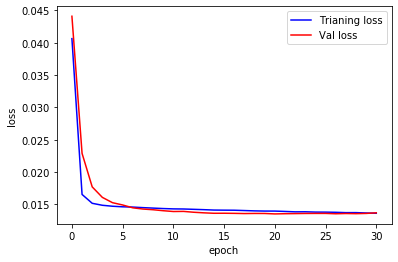

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['crps']

epochs = range(len(loss))

plt.plot(epochs, loss, '-b', label='Trianing loss')
plt.plot(epochs, val_loss, '-r', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Sequence Model

In this model, each game will be one sample of dataset, each play in this game will be a step (sequence) of this data. Therefore, I need to preprocess the data again.


The basic idea of this model is we treat the plays as a time sequence events. Each event is depend on the previous event. And the whole game is related to the objective factors, such as weather, home team or visit team.


According to this assumption, I used RNN based model to predict how many yards a team can gain.

#### Split data into two subset

1. Objective factors, such as weather, home or away
2. Time series features, such as current scores, who is the rusher in the current play.

In [32]:
def feature_engineering_seq_model():
    num_games = train['GameId'].unique().shape[0]
    max_plays = train['GameId'].value_counts().max()

    print('Total number of games:', num_games)
    print('Max number of plays in one game:', max_plays)
    
    sequence_feature_columns = [
        'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'Down', 'Distance', 'FieldPosition',
        'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffenseFormation', 'OffensePersonnel',
        'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'Duration', 'PlayerAge', 'PlayerHeight', 
        'PlayerWeight', 'Position'
    ]


    objective_feature_columns = [
        'Week', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity',
        'WindSpeed', 'WindDirection'
    ]

In [33]:
def generate_dataset_seq_model():
    obj_train = np.zeros((num_games, len(objective_feature_columns)))
    home_train = np.zeros((num_games, int(max_plays / 22), len(sequence_feature_columns) * 11 + 1))
    away_train = np.zeros((num_games, int(max_plays / 22), len(sequence_feature_columns) * 11 + 1))
    y_train = np.zeros((num_games, int(max_plays / 22), 199))
    y_idx = 0

    for idx, game_id in enumerate(game_ids):
        game = train.loc[train['GameId'] == game_id]

        obj_train[idx] = np.array(game[objective_feature_columns])[0]

        home_team = game.loc[game['Team'] == 0] # home team
        away_team = game.loc[game['Team'] == 1] # away team

        home_features = np.array(home_team[sequence_feature_columns]).reshape(-1, len(sequence_feature_columns) * 11)
        away_features = np.array(away_team[sequence_feature_columns]).reshape(-1, len(sequence_feature_columns) * 11)

        # add team col to the front of vector, home: 0, away:1
        home_features = np.pad(home_features, ((0, 0), (1, 0)), constant_values=0)  
        away_features = np.pad(away_features, ((0, 0), (1, 0)), constant_values=1)

        home_train[idx, :home_features.shape[0], :] = home_features
        away_train[idx, :home_features.shape[0], :] = home_features

        for i, yard in enumerate(game['Yards'][::22]):
            y_train[idx, i, yard+99:] = np.ones((1, 100-yard))


    print('obj_train shape:', obj_train.shape)
    print('home_train shape:', home_train.shape)
    print('away_train shape:', away_train.shape)
    print('y_train shape:', y_train.shape)


In [34]:
from keras.models import Model
from keras import layers
from keras import Input

num_hidden = 200
seq_num_features = len(sequence_feature_columns) * 11
max_plays = 1870

cell_state_input = Input(shape=[num_features], name='hidden_input')
cell_state_encoding = layers.Dense(num_hidden, activation='relu', name='hidden_encoder')(cell_state_input)
cell_state_encoding = layers.Dropout(0.5)(cell_state_encoding)

home_seq_input = Input(shape=[int(max_plays / 22), seq_num_features], name='home_sequence_input')
home_seq_encoding = layers.Dense(num_hidden, activation='relu', name='home_sequence_encoder')(home_seq_input)
home_seq_encoding = layers.Dropout(0.5)(home_seq_encoding)

away_seq_input = Input(shape=[int(max_plays / 22), seq_num_features], name='away_sequence_input')
away_seq_encoding = layers.Dense(num_hidden, activation='relu', name='away_sequence_encoder')(away_seq_input)
away_seq_encoding = layers.Dropout(0.5)(away_seq_encoding)

home_gru = layers.GRU(
    num_hidden, 
    return_sequences=True, 
    dropout=0.5, 
    name='home_gru')
home_gru_outputs = home_gru(home_seq_encoding, initial_state=[cell_state_encoding])

away_gru = layers.GRU(
    num_hidden, 
    return_sequences=True, 
    dropout=0.5, 
    name='away_gru')
away_gru_outputs = away_gru(away_seq_encoding, initial_state=[cell_state_encoding])

concatenated = layers.Concatenate()([home_gru_outputs, away_gru_outputs])
concatenated = layers.Dropout(0.5)(concatenated)
output = layers.Dense(199, activation='softmax', name='output_layer')(concatenated)

rnn_model = Model(inputs=[cell_state_input, home_seq_input, away_seq_input], outputs=[output])

rnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_sequence_input (InputLayer (None, 85, 253)      0                                            
__________________________________________________________________________________________________
hidden_input (InputLayer)       (None, 516)          0                                            
__________________________________________________________________________________________________
away_sequence_input (InputLayer (None, 85, 253)      0                                            
__________________________________________________________________________________________________
home_sequence_encoder (Dense)   (None, 85, 200)      50800       home_sequence_input[0][0]        
____________________________________________________________________________________________

In [35]:
# from keras import optimizers
# from keras.callbacks import EarlyStopping

# learning_rate = 1e-3

# rnn_model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=learning_rate), loss=crps)
# # rnn_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy')
# er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
# rnn_model.fit([obj_train, home_train, away_train], y_train, epochs=100, batch_size=1, validation_split=0.2)

## Submission

In [36]:
from tqdm.notebook import tqdm

iter_test = env.iter_test()
for test_df, sample_prediction_df in tqdm(iter_test):
    test = feature_engineering(test_df)
    x_test, _ = generate_dataset(test)
    
    y_pred = nn_model.predict(x_test)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)

env.write_submission_file()


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.
